# Hand Gesture Classification 
**using Spatio-Temporal Graph Convolutional Network**


**Dataset: IPN Hand Gestures**
https://gibranbenitez.github.io/IPN_Hand/

## Imports and config

In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.data import Batch

In [2]:
import pandas as pd
import os
import argparse
import numpy as np
import mediapipe as mp
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import networkx as nx

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#check if run in jupyter notebook (interactive) or as python file
def is_interactive(): 
    import __main__ as main
    return not hasattr(main, '__file__')

/net/pr2/projects/plgrid/plggrai/kzrobek/STG_CN/venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [3]:
if is_interactive():
    jupyter_args = f"--model_name=IPN_Hand_STGCN \
    --classes B0A G01 G03 D0X "
    print(jupyter_args)
    jupyter_args = jupyter_args.split()

--model_name=IPN_Hand_STGCN     --classes B0A G01 G03 D0X 


In [4]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="IPN_Hand_STGCN",
    help="will save ckpt for model in train_logs/model_name",
)
parser.add_argument(
    "--data_path", type=str, default="data",
    help="Path to IPN Hand Dataset, containing annotations/ and frames/",
)
parser.add_argument(
    "--classes", nargs='+', type=str, default=['B0A', 'G01', 'G03', 'D0X'],
    help="Choose classes to be recognized by the model. Options see https://gibranbenitez.github.io/IPN_Hand/",
)
parser.add_argument(
    "--sequence_len", type=int, default=20,
     help="Num of frames in the time window",
)
parser.add_argument(
    "--offset", type=int, default=10,
     help="Step in number of frames for shifting time window",
)
parser.add_argument(
    "--num_epochs", type=int, default=50,
     help="Number of training epochs",
)


if is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()
print(args)
# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)

# seed all random functions
seed=42
np.random.seed(seed)


# make ckpt output directory
os.makedirs(f"train_logs/{model_name}",exist_ok=True)

Namespace(model_name='IPN_Hand_STGCN', data_path='data', classes=['B0A', 'G01', 'G03', 'D0X'], sequence_len=20, offset=10, num_epochs=50)


## Loading IPN Hand Gesture Dataset

Annotations contain 
- video ID
- gesture classes contained in the video
- start and end frames of gesture classes in the video

In [5]:
annotations = pd.read_csv(f'{data_path}/annotations/Annot_List.txt')
filtered_annot = annotations[annotations['label'].isin(classes)] 
print(filtered_annot.head())
print(filtered_annot['label'].unique())

            video label  id  t_start  t_end  frames
0   1CM1_4_R_#229   D0X   1        1     17      17
7   1CM1_4_R_#229   G03   6      858    899      42
8   1CM1_4_R_#229   B0A   2      900   1122     223
9   1CM1_4_R_#229   D0X   1     1123   1432     310
11  1CM1_4_R_#229   B0A   2     1458   1707     250
['D0X' 'G03' 'B0A' 'G01']


In [6]:
class_dict = {class_label:i for i, class_label in enumerate(classes)}

### Extract Hand Keypoint Graphs from Dataframes

#### Example Frame

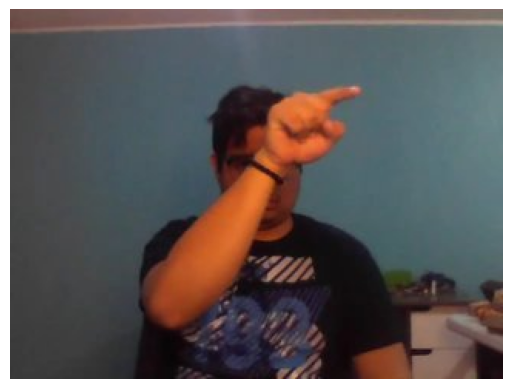

In [7]:
if is_interactive():

    example_frame_file = f"{data_path}/frames/1CM1_3_R_#228/1CM1_3_R_#228_000258.jpg"
    # Read the image using OpenCV
    example_frame = cv2.imread(example_frame_file)
    
    # Convert the image from BGR (OpenCV's default) to RGB (for Matplotlib)
    example_frame_rgb = cv2.cvtColor(example_frame, cv2.COLOR_BGR2RGB)
    
    # Display the image
    plt.imshow(example_frame_rgb)
    plt.axis('off')  # Optionally remove the axis for a cleaner display
    plt.show()


Gesture sequences are interpolated to the same length

In [7]:
# Load preprocessed graph data
graph_data = np.load(os.path.join(data_path,'graph_data.npy'))
labels_data = np.load(os.path.join(data_path,'labels_data.npy'))

In [8]:
# Access hand connections
mp_hands = mp.solutions.hands
connections = mp_hands.HAND_CONNECTIONS
EDGE_INDEX = np.array(list(connections)).T

# Print connections
print("Hand Connections:", EDGE_INDEX)

Hand Connections: [[ 3  0 17  0 13 13 18  5  5 14  0  9  1  9 10 19  6 15  2 11  7]
 [ 4  5 18 17 14 17 19  6  9 15  1 10  2 13 11 20  7 16  3 12  8]]


In [9]:
# take shortest gesture and try to recognize it by half of its length video window
NUM_FRAMES = sequence_len
NUM_JOINTS = 21  # Number of joints in the hand
NUM_FEATURES = 3  # (x, y, z) positions for each joint
NUM_CLASSES = len(classes)  # hand geature classes

print("NUM_FRAMES ", NUM_FRAMES)
print("NUM_JOINTS ", NUM_JOINTS)
print("NUM_FEATURES ", NUM_FEATURES)
print("NUM_CLASSES ", NUM_CLASSES)

NUM_FRAMES  20
NUM_JOINTS  21
NUM_FEATURES  3
NUM_CLASSES  4


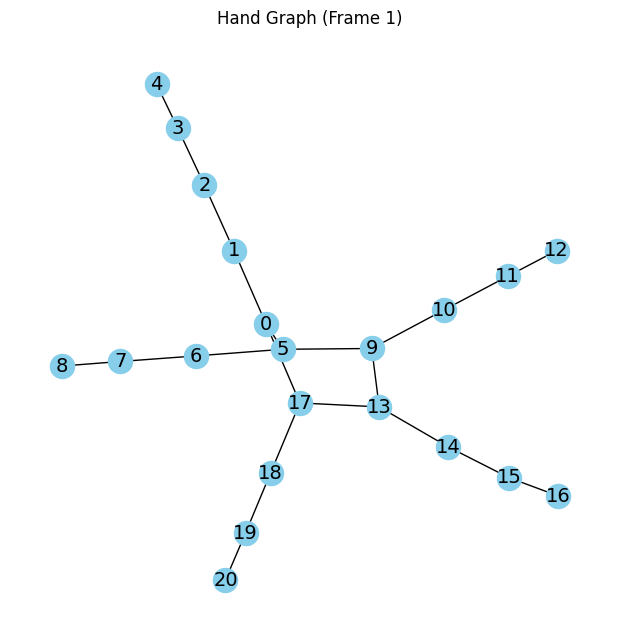

In [12]:
# Visualize the graph 
G = nx.Graph()
for i in range(NUM_JOINTS):
    G.add_node(i)
for edge in EDGE_INDEX.T:
    G.add_edge(edge[0].item(), edge[1].item())

# Visualizing the skeleton graph
plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=300, node_color='skyblue', font_size=14)
plt.title('Hand Graph (Frame 1)')
plt.savefig(f"hand_graph.png", dpi=300)

### Parsing data into troch_geometric

In [10]:
def parse_data4model(data, labels_data):
        
        all_data_frames = []  # Store data_frames for all batches
        
        for gesture_data, label in zip(data, labels_data):
        
            # Extract x_data from the batch
            x_data = torch.tensor(gesture_data, dtype=torch.float32)
        
            # Create data_frames for each time step
            data_frames = []
            if label == -1: label = 0
            
            for t in range(NUM_FRAMES):
                data_frame = Data(x=x_data[t], edge_index=torch.tensor(EDGE_INDEX), y=torch.tensor(label).unsqueeze(0))
                data_frames.append(data_frame)
            
            all_data_frames.append(Batch.from_data_list(data_frames))
    
        return all_data_frames
    
data_frames = parse_data4model(graph_data, labels_data)

print("Number of sequences:", len(data_frames))
print("Number of graphs (frames) in a sequence:", data_frames[0].num_graphs)
print("Shape of x_data in single graph:", data_frames[0][0].x.shape)

train_data_frames, test_data_frames = train_test_split(data_frames, test_size=0.2, random_state=42)
print(f"\nNumber of train data: {len(train_data_frames)}  Number of test data: {len(test_data_frames)}")

Number of sequences: 1305
Number of graphs (frames) in a sequence: 20
Shape of x_data in single graph: torch.Size([21, 3])

Number of train data: 1044  Number of test data: 261


# Create the model

In [13]:
from STGCN import STGCN
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# Initialize the model
model = STGCN(in_channels=NUM_FEATURES, out_channels=NUM_CLASSES, num_joints=NUM_JOINTS, num_frames=NUM_FRAMES)

# Move the model to the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print the model architecture
print(model)
example = train_data_frames[0].to(device)
print(train_data_frames[0])
out = model(example)
print("Dummy prediction", out.argmax(dim=1))

STGCN(
  (conv1): GCNConv(3, 64)
  (conv2): GCNConv(64, 128)
  (temporal_conv): Conv2d(128, 128, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (fc): Linear(in_features=53760, out_features=4, bias=True)
)
DataBatch(x=[420, 3], edge_index=[2, 420], y=[20], batch=[420], ptr=[21])
Dummy prediction tensor([0], device='cuda:0')


# Training the ST-GCN

In [49]:
# Define a function to save the model checkpoint
def save_checkpoint(model, optimizer, epoch, loss, filename="last.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved at {filename}")


In [53]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
print("Scheduled epochs: ", num_epochs)

Scheduled epochs:  50


In [17]:
# Weights and Biases 
import wandb
wandb.init(
    # set the wandb project where this run will be logged
    project="Hand_Gesture_Recog",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.001,
    "architecture": "STGCN",
    "dataset": "IPN_Hand_Gesture",
    "epochs": num_epochs,
    }
)

wandb: Currently logged in as: karolina-m-zrobek (karolina-m-zrobek-agh). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


## Training Loop

In [51]:
from tqdm import tqdm

for epoch in range(num_epochs):
    # TRAIN
    model.train()
    accuracy_scores_train = []
    losses_train= []
    for data_frame in tqdm(train_data_frames):
        data_frame.to(device)
        optimizer.zero_grad()
        # Concatenate data frames along time dimension
        out = model(data_frame)  # Only passing one frame for simplicity here (modify for sequence)

        true_class = data_frame[0].y
        pred_class = torch.argmax(out, dim=1)  # Get the predicted class
        
        # Compute loss and backpropagate
        loss = criterion(out, true_class)
        losses_train.append(loss.item())
        loss.backward()
        optimizer.step()

        accuracy = (pred_class == true_class).float().mean()
        accuracy_scores_train.append(accuracy.item())

        
    print(f'Epoch {epoch}, Train Loss: {np.mean(np.array(losses_train))}, Train Acc: {np.mean(np.array(accuracy_scores_train))}')
    wandb.log({"train/acc": np.mean(np.array(accuracy_scores_train)), "train/loss": np.mean(np.array(losses_train))})
    save_checkpoint(model, optimizer, epoch, loss,os.path.join('train_logs', model_name, 'last.pth' ))


    # TEST
    model.eval()
    with torch.no_grad():
        accuracy_scores_test = []
        losses_test = []
        for data_frame in test_data_frames:
            data_frame.to(device)
            out = model(data_frame)  # Run the forward pass
            true_class = data_frame[0].y
            pred_class = torch.argmax(out, dim=1)  # Get the predicted class
            
            loss = criterion(out, true_class)
            losses_test.append(loss.item())

            accuracy = (pred_class == true_class).float().mean()
            accuracy_scores_test.append(accuracy.item())

    print(f'Epoch {epoch}, Test Loss: {np.mean(np.array(losses_test))}, Test Acc: {np.mean(np.array(accuracy_scores_test))}')
    wandb.log({"test/acc": np.mean(np.array(accuracy_scores_test)), "test/loss": np.mean(np.array(losses_test))})

wandb.finish()

100%|██████████| 159/159 [00:03<00:00, 49.99it/s]


Epoch 0, Train Loss: 0.9541243690786496, Train Acc: 0.5849056603773585
Checkpoint saved at train_logs/IPN_Hand_STGCN/last.pth
Epoch 0, Test Loss: 0.48713461123406887, Test Acc: 0.775
